# Métricas

En este Notebook vamos analizar distintas métricas y algoritmos sobre un problema de clasificación desbalanceado. Ya hemos visto las principales métricas de regresión (MSE y RMSE) así que no nos detendremos en ellas aquí.

1. Análisis exploratorio
2. Métricas clasificación
3. Comparación clasificadores

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
from utils import plot_confusion_matrix, CM_BRIGHT

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Definimos una función para calcular y representar las métricas:

In [2]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# 0. División train/test

Esta vez vamos a hacer las cosas bien hechas y dividiremos antes de hacer ningún tipo de análisis:

In [3]:
from sklearn.model_selection import train_test_split

full_df = pd.read_csv('data/churn.csv', sep=',')
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, stratify=full_df['churn'], random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./data/churn_train.csv', sep=',', index=False)
test.to_csv('./data/churn_test.csv', sep=',', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

Dimensiones del dataset de training: (2666, 21)
Dimensiones del dataset de test: (667, 21)


# 1. Análisis exploratorio

Vamos a trabajar con datos de fuga de una compañía telefónica. El objetivo es predecir si los clientes van a abandonar la compañía.

<div class = "alert alert-success">
EJERCICIO 8.1: Carga los datos *churn_train.csv* y realiza un primer análisis.
</div>

<div class = "alert alert-success">
EJERCICIO 8.2: Este problema está desbalanceado; calcula el ratio de desbalanceo.
</div>

In [4]:
# ... código aquí: carga de datos
data = pd.read_csv('data/churn_train.csv', sep=',')

In [6]:
data.head().T

,0,1,2,3,4
state,ID,AR,ME,VT,WY
account length,82,115,28,195,139
area code,408,415,415,415,415
phone number,352-7413,385-7157,402-5014,377-7843,337-7501
international plan,no,no,no,no,no
voice mail plan,no,no,no,yes,no
number vmail messages,0,0,0,36,0
total day minutes,101.0,139.3,236.8,231.7,192.8
total day calls,93,89,102,110,104
total day charge,17.17,23.68,40.26,39.39,32.78


In [7]:
# ... código aquí: desbalanceo
data['churn'].value_counts()

churn
False    2280
True      386
Name: count, dtype: int64

##  1.1 Preprocesamiento de variables

Si escribimos *data.dtypes* nos indica el tipo de las variables de nuestro dataframe. Vemos que tenemos variables categóricas que tenemos que codificar:

In [9]:
data.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

<div class = "alert alert-success">
EJERCICIO 8.3: Elimine la variable *phone number* y codifique las variables categóricas con un Label Encoder.
</div>

In [10]:
# ... código aquí: elimina phone number
data = data.drop(['phone number'], axis=1)
data.head().T

,0,1,2,3,4
state,ID,AR,ME,VT,WY
account length,82,115,28,195,139
area code,408,415,415,415,415
international plan,no,no,no,no,no
voice mail plan,no,no,no,yes,no
number vmail messages,0,0,0,36,0
total day minutes,101.0,139.3,236.8,231.7,192.8
total day calls,93,89,102,110,104
total day charge,17.17,23.68,40.26,39.39,32.78
total eve minutes,155.6,192.3,167.1,225.1,234.4


In [11]:
# ... código aquí: codificación
from sklearn.preprocessing import LabelEncoder

le_state = LabelEncoder()
le_international = LabelEncoder()
le_vmp = LabelEncoder()
le_churn = LabelEncoder()

data['state'] = le_state.fit_transform(data['state'])
print(le_state.classes_)

data['international plan'] = le_international.fit_transform(data['international plan'])
print(le_international.classes_)

data['voice mail plan'] = le_vmp.fit_transform(data['voice mail plan'])
print(le_vmp.classes_)

data['churn'] = le_churn.fit_transform(data['churn'])
print(le_churn.classes_)

['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']
['no' 'yes']
['no' 'yes']
[False  True]


In [12]:
data.head().T

,0,1,2,3,4
state,13.00,2.00,21.00,46.00,50.00
account length,82.00,115.00,28.00,195.00,139.00
area code,408.00,415.00,415.00,415.00,415.00
international plan,0.00,0.00,0.00,0.00,0.00
voice mail plan,0.00,0.00,0.00,1.00,0.00
number vmail messages,0.00,0.00,0.00,36.00,0.00
total day minutes,101.00,139.30,236.80,231.70,192.80
total day calls,93.00,89.00,102.00,110.00,104.00
total day charge,17.17,23.68,40.26,39.39,32.78
total eve minutes,155.60,192.30,167.10,225.10,234.40


<div class = "alert alert-success">
EJERCICIO 8.4: Represente el histograma de las variable con distintos colores para cada clase.
</div>

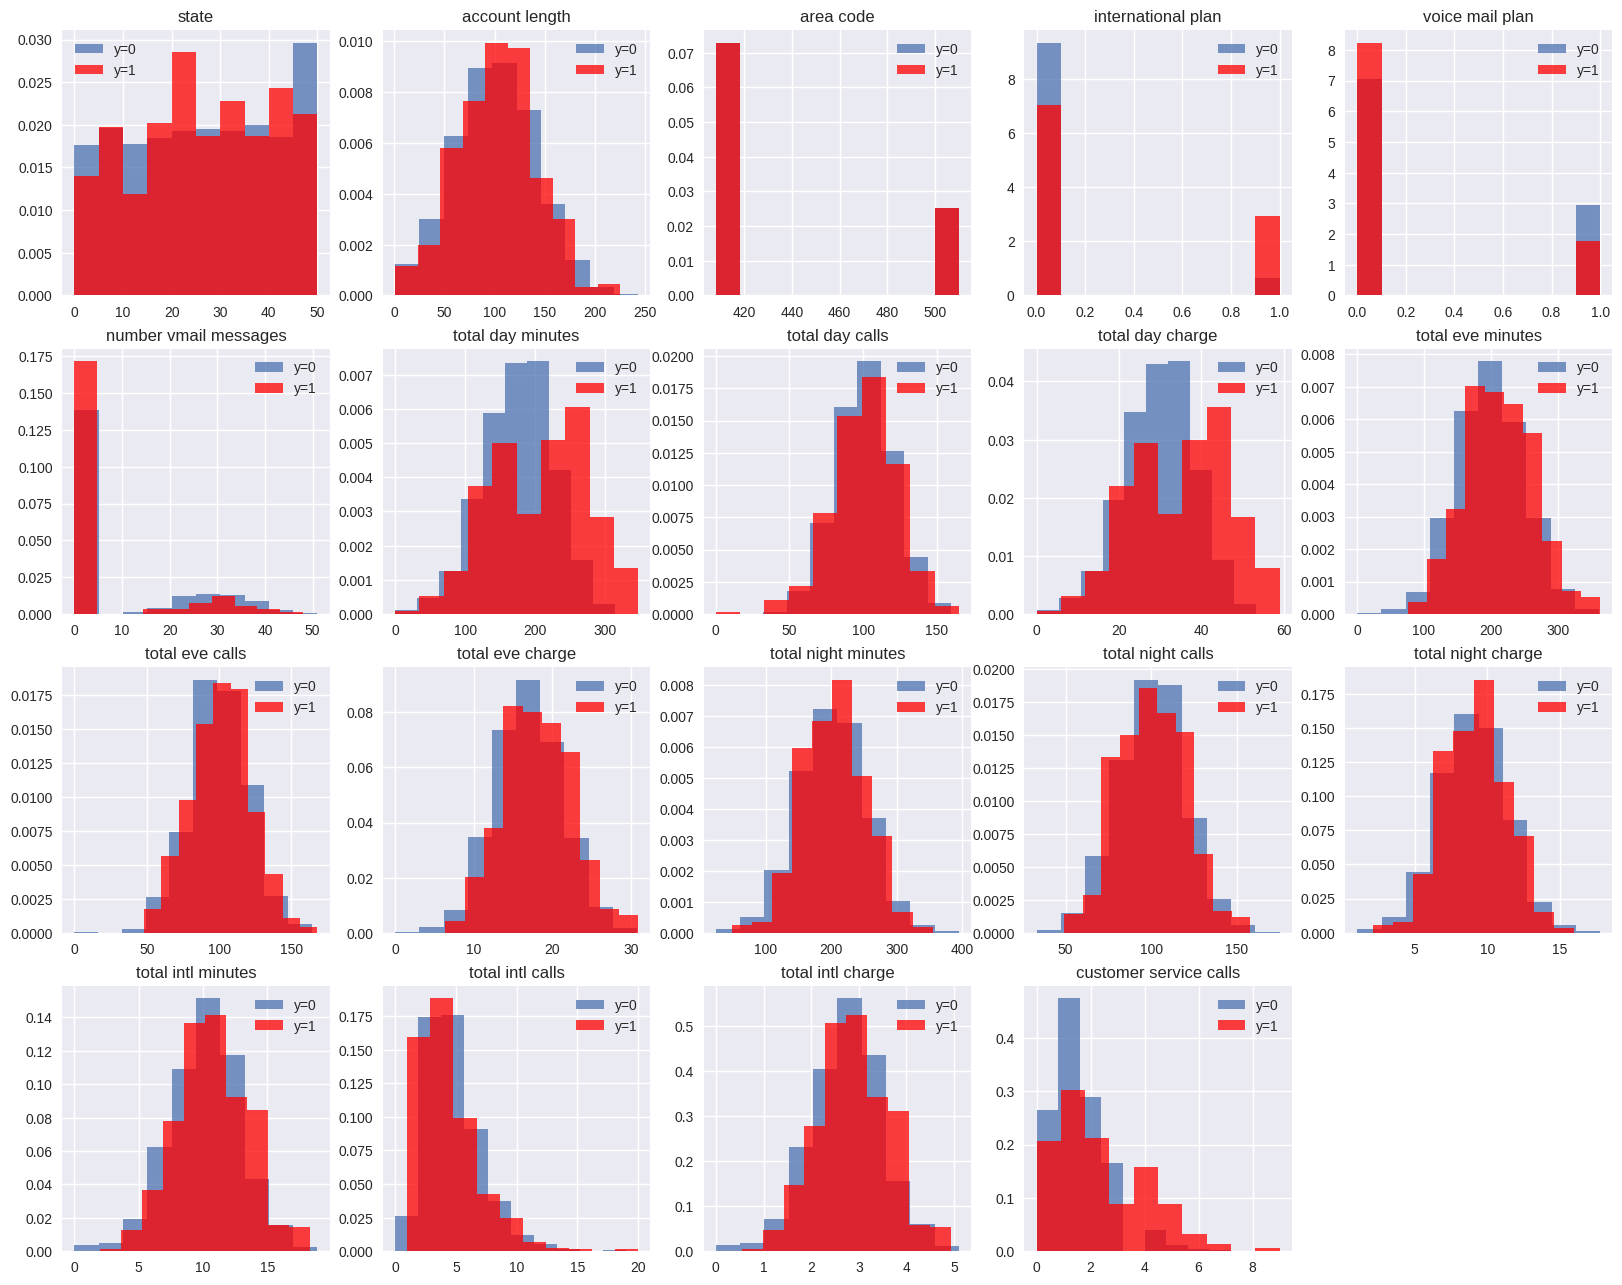

In [15]:
# ... código aquí: histogramas
plt.figure(figsize=(20,20))

idx_0 =  data['churn'] == 0
idx_1 =  data['churn'] == 1

for i,feature in enumerate(data.columns.drop(['churn'])):
    plt.subplot(5,5,i+1)   
    plt.hist(data.loc[idx_0,feature],density=1, alpha=0.75,label='y=0')
    plt.hist(data.loc[idx_1,feature],density=1, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

## 1.2 Correlación entre variables

<div class = "alert alert-success">
EJERCICIO 8.5: Representa el mapa de correlación entre variables.
</div>

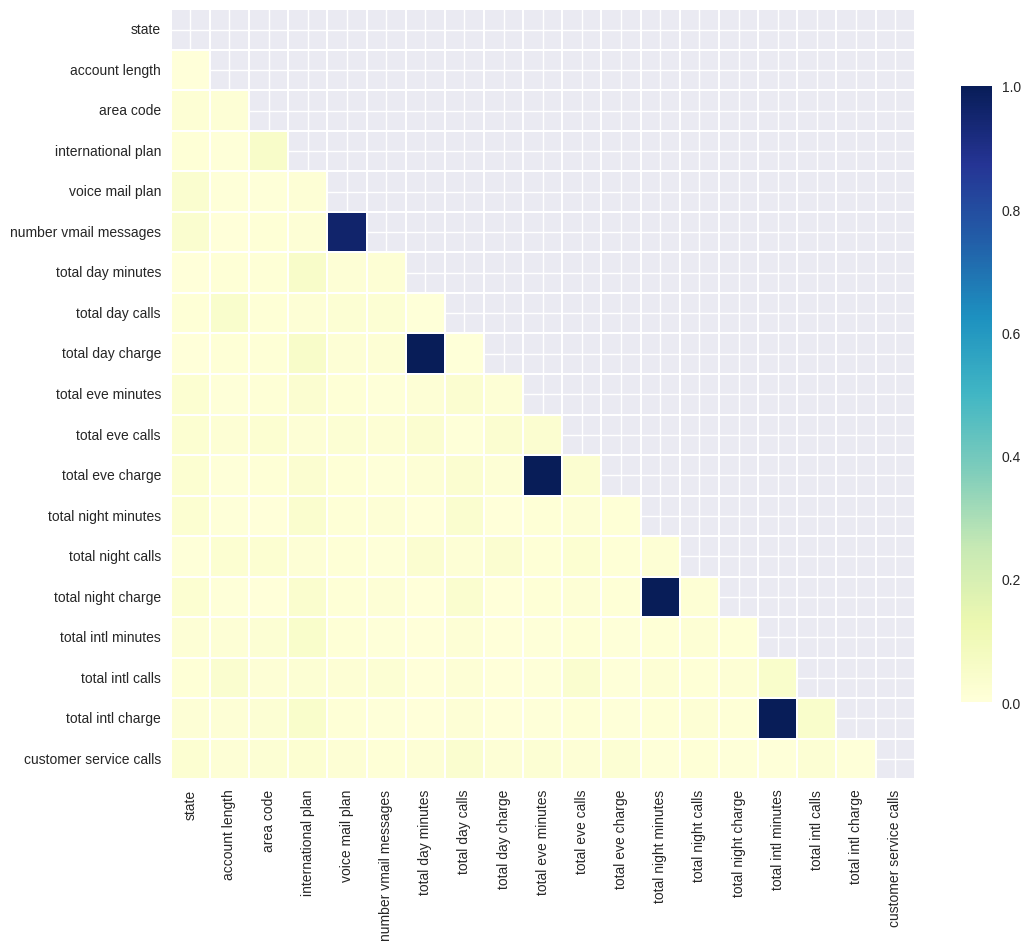

In [16]:
import seaborn as sns

# ... código aquí: correlación

# Compute the correlation matrix
corr = np.abs(data.drop(['churn'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Podemos pintar las variables más correlacionadas (>0.95) con un scatter plot, para ver qué tipo de relación tienen:

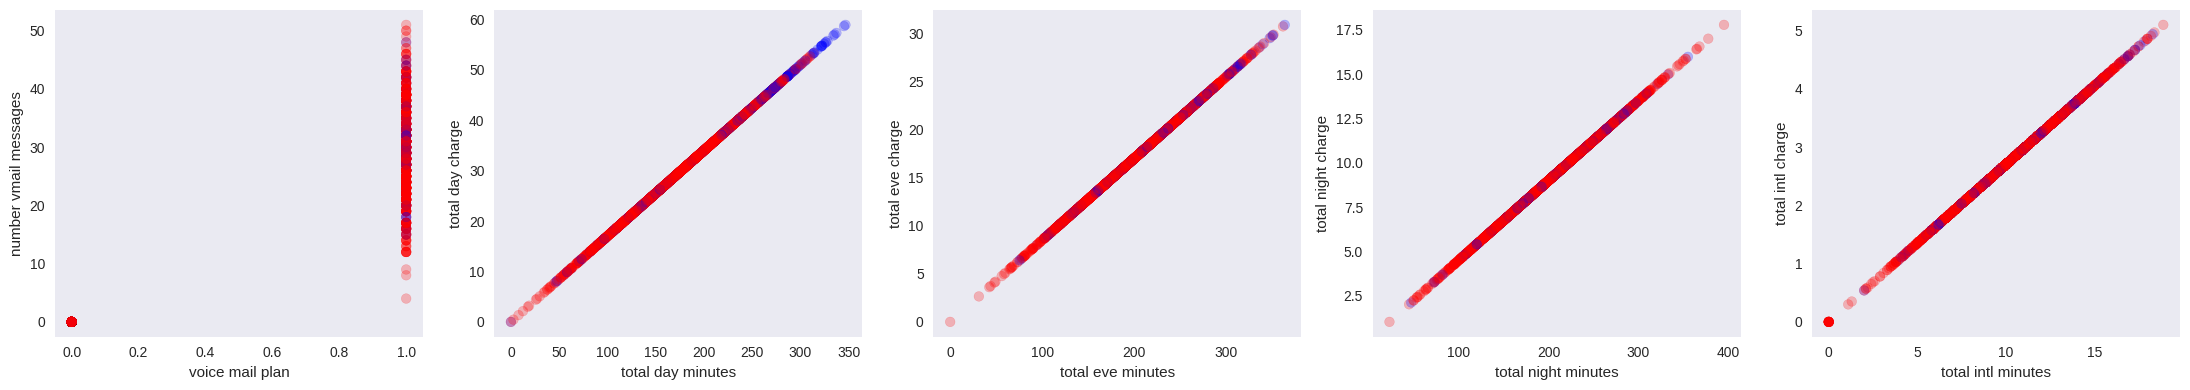

In [17]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
threshold = 0.95
pairs = np.where(upper>threshold)
fx = data.columns[pairs[0]]
fy =  data.columns[pairs[1]]

i=1
plt.figure(figsize=(22,4))
for f1,f2 in zip(fx,fy):
    
    plt.subplot(1,5,i)
    
    plt.scatter(data[f1],data[f2], c=data['churn'],cmap=CM_BRIGHT, alpha=0.25)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid()
    plt.tight_layout()
    
    i+=1
    
plt.show()

Dada la correlación extrema y con el objetivo de eliminar variables poco informativas, podemos eliminar algunas columnas:

In [18]:
columns_to_drop = ['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes']
data = data.drop(columns_to_drop, axis=1)
data.head().T

,0,1,2,3,4
state,13.00,2.00,21.00,46.00,50.00
account length,82.00,115.00,28.00,195.00,139.00
area code,408.00,415.00,415.00,415.00,415.00
international plan,0.00,0.00,0.00,0.00,0.00
voice mail plan,0.00,0.00,0.00,1.00,0.00
number vmail messages,0.00,0.00,0.00,36.00,0.00
total day calls,93.00,89.00,102.00,110.00,104.00
total day charge,17.17,23.68,40.26,39.39,32.78
total eve calls,104.00,95.00,87.00,88.00,96.00
total eve charge,13.23,16.35,14.20,19.13,19.92


Es buena idea agrupar todo el análisis y preprocesamiento en una única celda

In [20]:
# RESUMO MI ANÁLISIS COMPLETO
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('data/churn_train.csv', sep=',')

# Elimino phone number
data = data.drop(['phone number'], axis=1)

# Codifico las variables categóricas
le_state = LabelEncoder()
le_ip = LabelEncoder()
le_vmp = LabelEncoder()
le_churn = LabelEncoder()

data['state'] = le_state.fit_transform(data['state'])
data['international plan'] = le_ip.fit_transform(data['international plan'])
data['voice mail plan'] = le_vmp.fit_transform(data['voice mail plan'])
data['churn'] = le_churn.fit_transform(data['churn'])

# Elimino columnas muy correlacionadas
columns_to_drop = ['total day minutes','total eve minutes','total night minutes','total intl minutes']
data = data.drop(columns_to_drop, axis=1)

print(data.shape)
data.head()

(2666, 16)


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls,churn
0,13,82,408,0,0,0,93,17.17,104,13.23,93,13.70,2,3.59,0,0
1,2,115,415,0,0,0,89,23.68,95,16.35,75,6.80,3,2.51,7,1
2,21,28,415,0,0,0,102,40.26,87,14.20,115,12.61,3,2.62,3,0
3,46,195,415,0,1,36,110,39.39,88,19.13,89,9.08,2,3.27,0,0
4,50,139,415,0,0,0,104,32.78,96,19.92,101,9.14,3,3.51,3,0


Porque así puedo aplicarlo muy fácilmente a test:

In [21]:
data_test = pd.read_csv('data/churn_test.csv', sep=',')

# Elimino phone number
data_test = data_test.drop(['phone number'], axis=1)

# Codifico las variables categóricas
# con los mismos LabelEncoder de train, porque quiero conservar las clases

# data_test['state'].apply(x: x = 'Unknown' if x not in le_state.classes_)

data_test['state'] = le_state.transform(data_test['state'])
data_test['international plan'] = le_ip.transform(data_test['international plan'])
data_test['voice mail plan'] = le_vmp.transform(data_test['voice mail plan'])
data_test['churn'] = le_churn.transform(data_test['churn'])

# Elimino columnas muy correlacionadas
columns_to_drop = ['total day minutes','total eve minutes','total night minutes','total intl minutes']
data_test = data_test.drop(columns_to_drop, axis=1)

print(data_test.shape)
data_test.head()

(667, 16)


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls,churn
0,34,94,415,0,0,0,91,32.37,107,7.82,108,10.12,17,3.67,2,0
1,23,40,510,0,0,0,123,13.89,108,17.87,64,9.54,3,3.05,6,1
2,34,68,415,0,1,29,82,40.72,105,17.32,70,7.55,6,2.67,0,0
3,49,121,415,0,0,0,110,17.56,82,10.97,113,7.52,3,2.89,0,0
4,42,94,408,1,0,0,113,28.92,94,23.10,78,4.98,4,2.35,1,0


# 2. Métricas en clasificación

Vamos a representar la matriz de confusión, y a partir de ella calcular distintas métricas. Para ello, comencemos un clasificador sencillo: regresión logística.

In [22]:
from sklearn.preprocessing import StandardScaler

# preparamos los datos, un pelín distinto de otras veces
features = data.drop(['churn'], axis=1).columns

X_train = data[features].values
y_train = data['churn'].values

X_test = data_test[features].values
y_test = data_test['churn'].values

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Proporcion train:%0.3f'%np.mean(y_train))
print('Proporcion test: %0.3f'%np.mean(y_test))


Datos train:  (2666, 15)
Datos test:   (667, 15)
Proporcion train:0.145
Proporcion test: 0.145


## 2.1 Matriz de confusión y métricas

<div class = "alert alert-success">
EJERCICIO 8.6: Ajuste un algoritmo de regresión logística sobre el conjunto de entrenamiento con $C = 1$. Calcule la predicción para el conjunto de entrenamiento (*y_pred*).
</div>

In [25]:
from sklearn.linear_model import LogisticRegression

# ... código aquí
lr = LogisticRegression(C=1).fit(Xs_train, y_train)
y_pred = lr.predict(Xs_train)

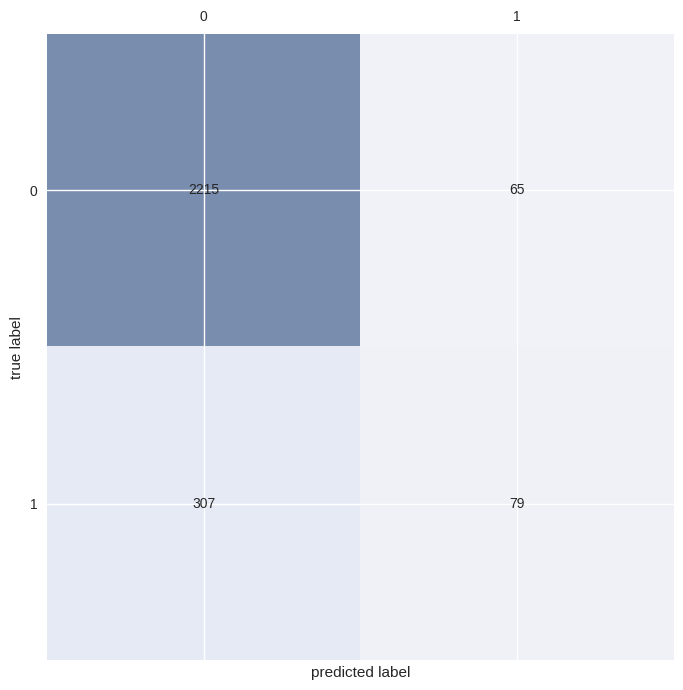

In [26]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_train,y_pred)
plot_confusion_matrix(confmat)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_train,y_pred).ravel()

ACC:  0.8604651162790697
SEN:  0.20466321243523317
ESP:  0.9714912280701754
PPV:  0.5486111111111112
FSC:  0.2981132075471698


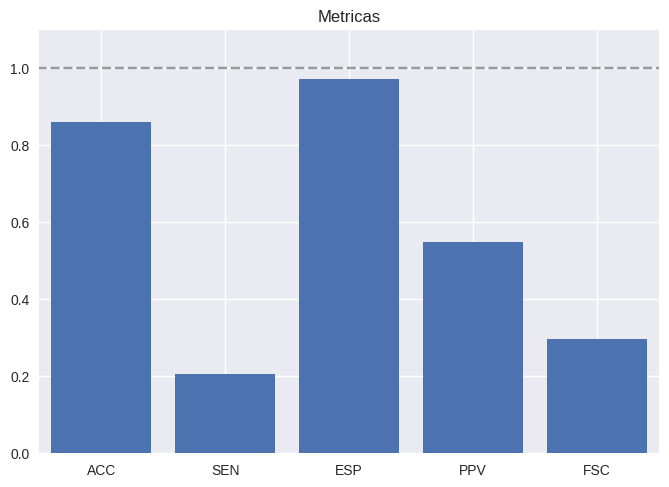

In [27]:
calcula_metricas(confmat)

<div class = "alert alert-success">
EJERCICIO 8.7: Calcule la predicción para el conjunto de test (*y_pred_test*).
</div>

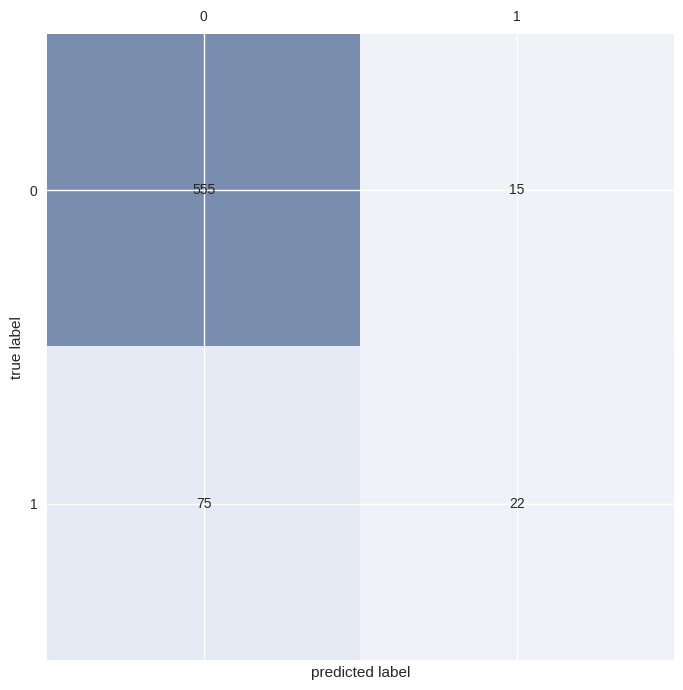

ACC:  0.8650674662668666
SEN:  0.2268041237113402
ESP:  0.9736842105263158
PPV:  0.5945945945945946
FSC:  0.3283582089552239


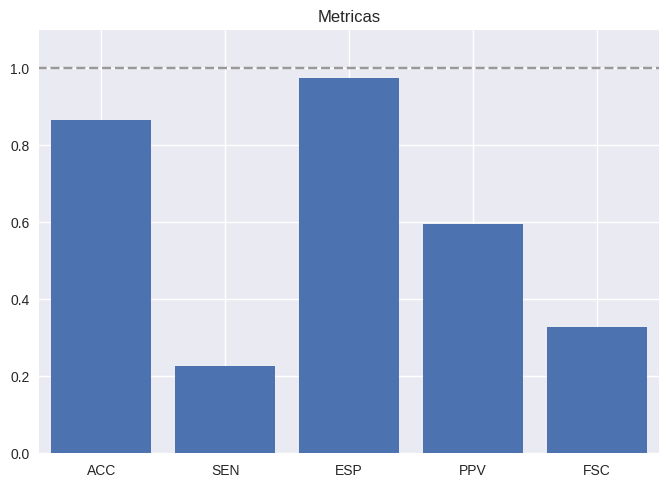

In [28]:
y_pred_test = lr.predict(Xs_test)

confmat = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

Ahora representamos de nuevo los histogramas:

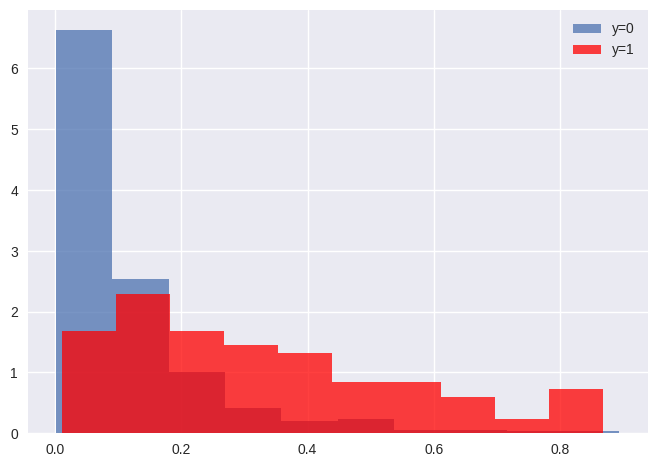

In [29]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_prob[idx_0],density=1, alpha=0.75,label='y=0')
plt.hist(y_prob[idx_1],density=1, facecolor='red', alpha=0.75,label='y=1')
plt.legend()

plt.show()

Por último, vamos a representar la curva ROC.

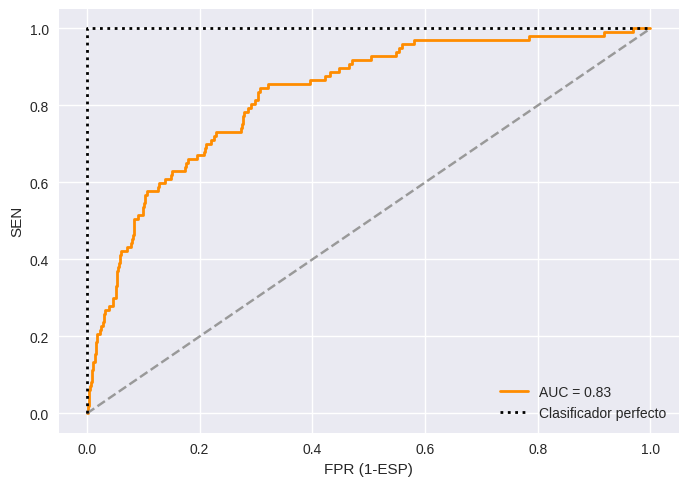

In [30]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

# 3. Comparación clasificadores

Vamos a comparar los siguientes clasificadores: 

* Regresión logística
* Árboles de decisión
* Random Forest

## 3.1 Regresión logística

Hemos visto que este algoritmo está sesgado hacia la clase mayoritoria. Para compensar esta situación, podemos asignar pesos distintos a los errores cometidos en cada una de las clases, a través del parámetro [*class_weight*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Además, podemos trabajar con distintas [métricas](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) a la hora de optimizar los parámetros libres. Para conjuntos desbalancedados es adecuada 'f1': F1-score, compromiso entre SEN y PPV.


best mean cross-validation score: 0.776
best parameters: {'C': 0.001}


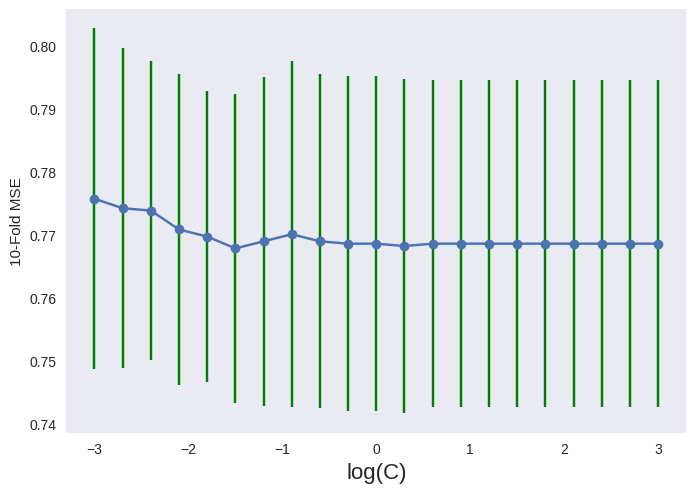

In [31]:
from sklearn.model_selection import GridSearchCV

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(
    LogisticRegression(random_state=0, class_weight='balanced'),
    scoring='accuracy', 
    param_grid=param_grid, 
    cv = 5
)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

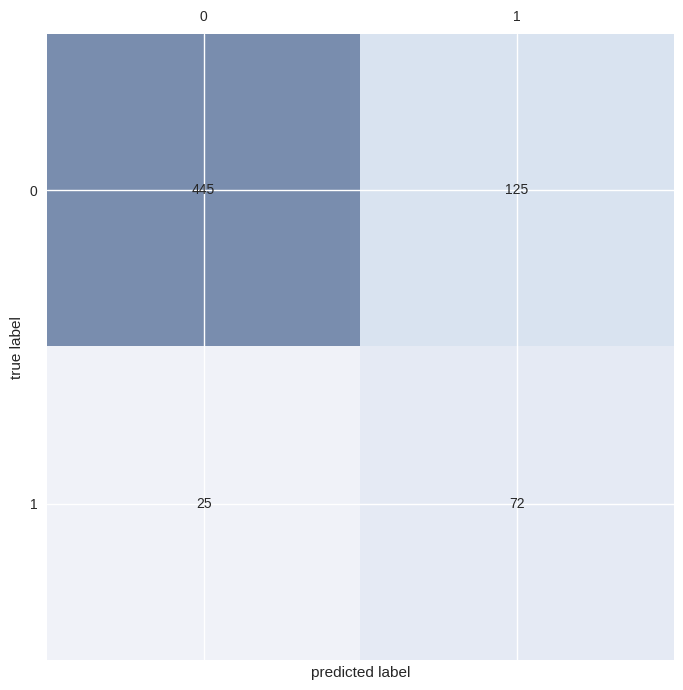

ACC:  0.775112443778111
SEN:  0.7422680412371134
ESP:  0.7807017543859649
PPV:  0.36548223350253806
FSC:  0.48979591836734687


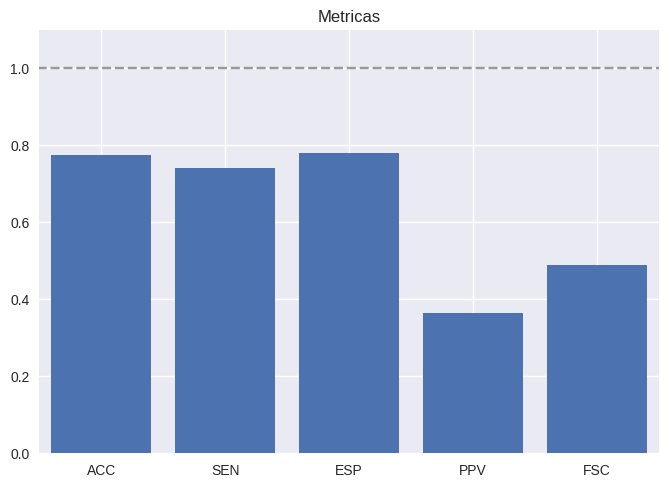

In [34]:
lr = LogisticRegression(C=grid.best_params_['C'], class_weight='balanced').fit(Xs_train, y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

<div class = "alert alert-success">
EJERCICIO 8.8: El código de arriba optimiza balanceado y con accuracy. Compare el resultado con respecto a entrenar tres combinaciones: sin balancear + accuracy; sin balancear + F1; balanceado + F1.
</div>

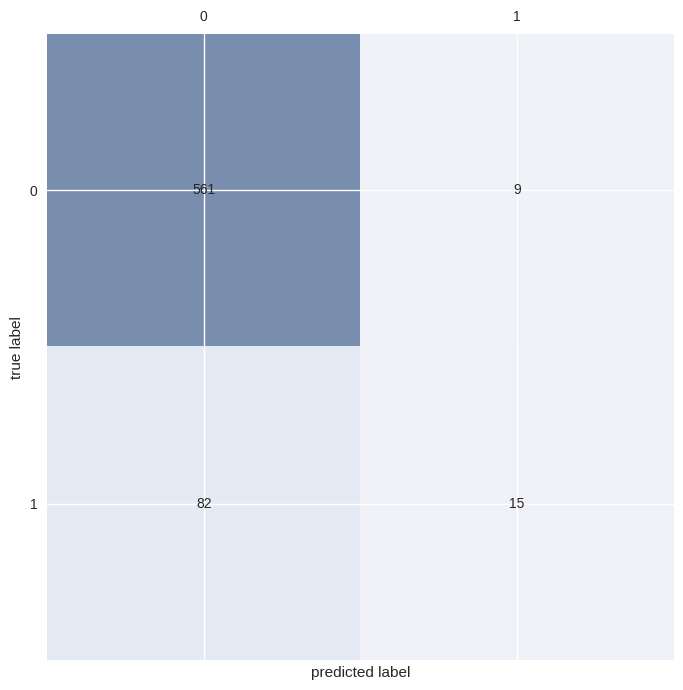

ACC:  0.863568215892054
SEN:  0.15463917525773196
ESP:  0.9842105263157894
PPV:  0.625
FSC:  0.24793388429752067


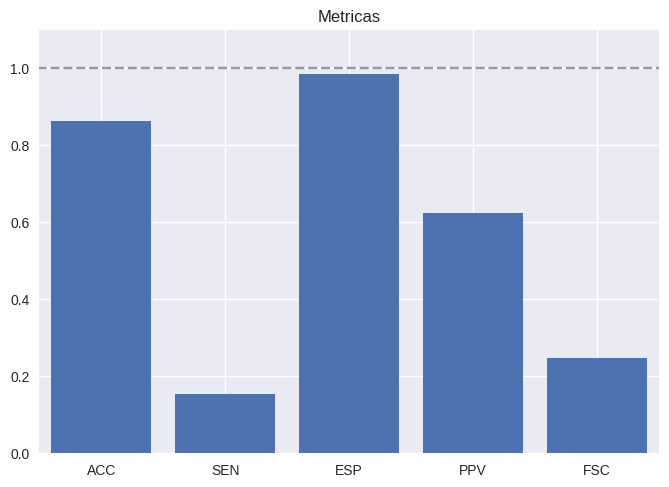

In [35]:
# ...código aquí: not balanced + ACC
grid = GridSearchCV(
    LogisticRegression(random_state=0),
    scoring='accuracy', 
    param_grid=param_grid, 
    cv = 5
).fit(Xs_train, y_train)

Copt = grid.best_params_['C']

lr = LogisticRegression(C=grid.best_params_['C']).fit(Xs_train, y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

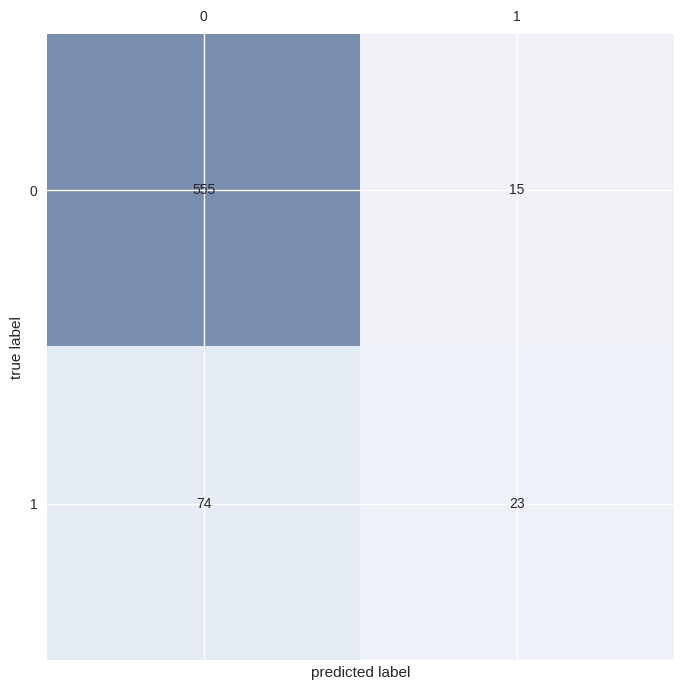

ACC:  0.8665667166416792
SEN:  0.23711340206185566
ESP:  0.9736842105263158
PPV:  0.6052631578947368
FSC:  0.3407407407407408


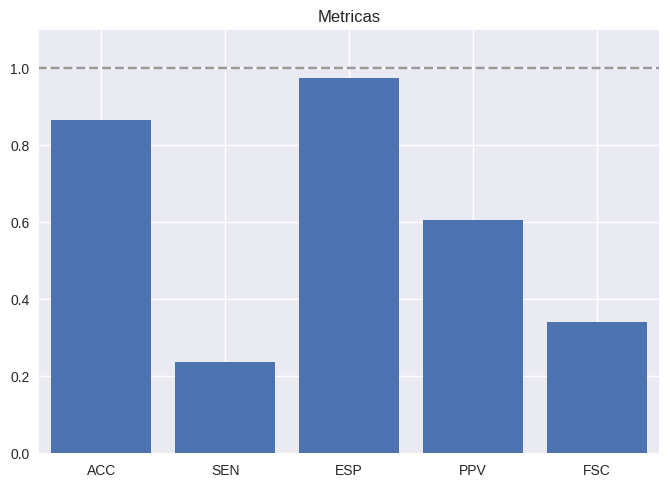

In [36]:
# ...código aquí: not balanced + F1
grid = GridSearchCV(
    LogisticRegression(random_state=0),
    scoring='f1', 
    param_grid=param_grid, 
    cv = 5
).fit(Xs_train, y_train)
Copt = grid.best_params_['C']

lr = LogisticRegression(C=grid.best_params_['C']).fit(Xs_train, y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

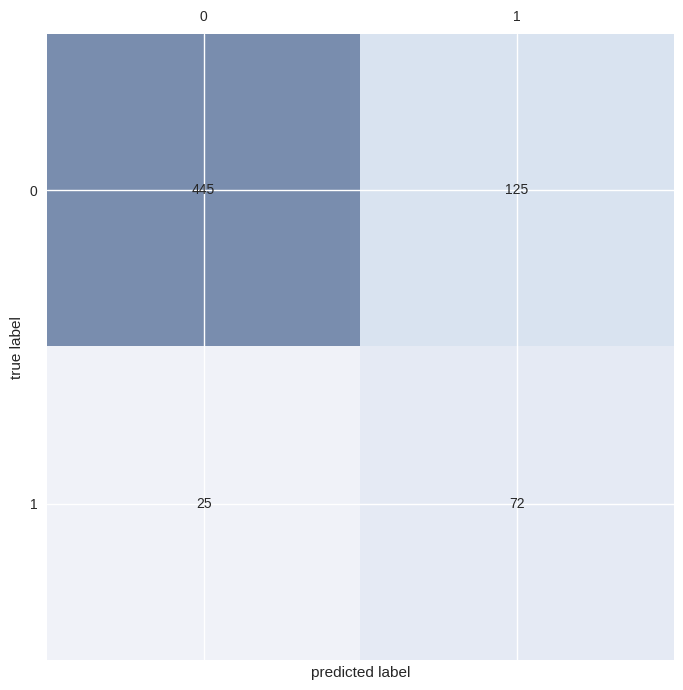

ACC:  0.775112443778111
SEN:  0.7422680412371134
ESP:  0.7807017543859649
PPV:  0.36548223350253806
FSC:  0.48979591836734687


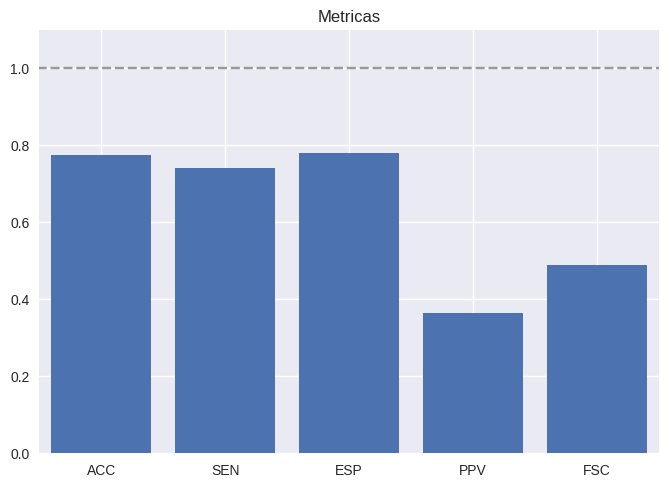

In [37]:
# ...código aquí: balanced + F1
grid = GridSearchCV(
    LogisticRegression(random_state=0, class_weight='balanced'),
    scoring='f1', 
    param_grid=param_grid, 
    cv = 5
).fit(Xs_train, y_train)
Copt = grid.best_params_['C']

lr = LogisticRegression(C=grid.best_params_['C'], class_weight='balanced').fit(Xs_train, y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Vamos a representar histogramas para esta última:

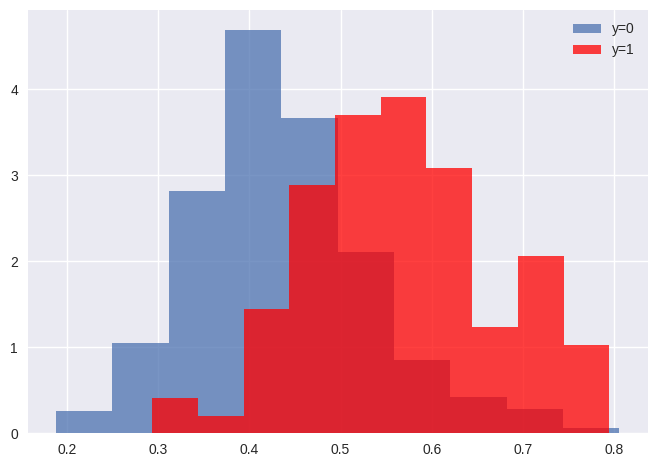

In [38]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_prob[idx_0],density=1, alpha=0.75,label='y=0')
plt.hist(y_prob[idx_1],density=1, facecolor='red', alpha=0.75,label='y=1')
plt.legend()

plt.show()

Y la curva ROC:

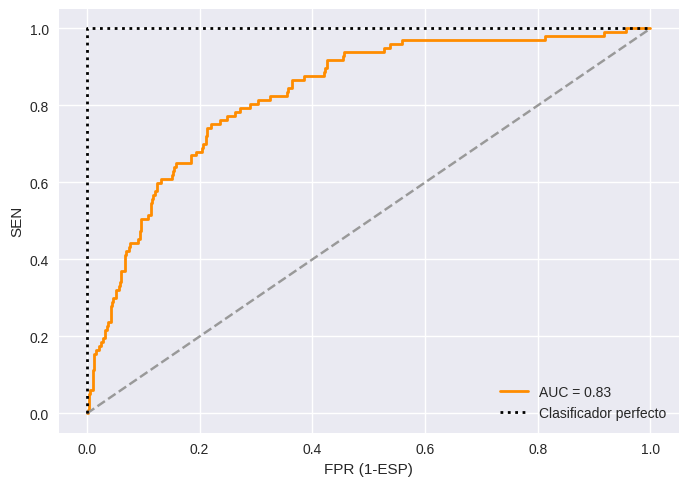

In [39]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

## 3.2 Árboles de decisión

Entrenamos ahora un árbol de decisión. Otra ventaja adicional de los árboles es que por su construcción hace frente al desbalanceo de las clases.

<div class = "alert alert-success">
EJERCICIO 8.9: Entrena un árbol de decisión y calcula las métricas obtenidas en el conjunto de test.
</div>

Fitting 5 folds for each of 14 candidates, totalling 70 fits
best mean cross-validation score: 0.934
best parameters: {'max_depth': 8}


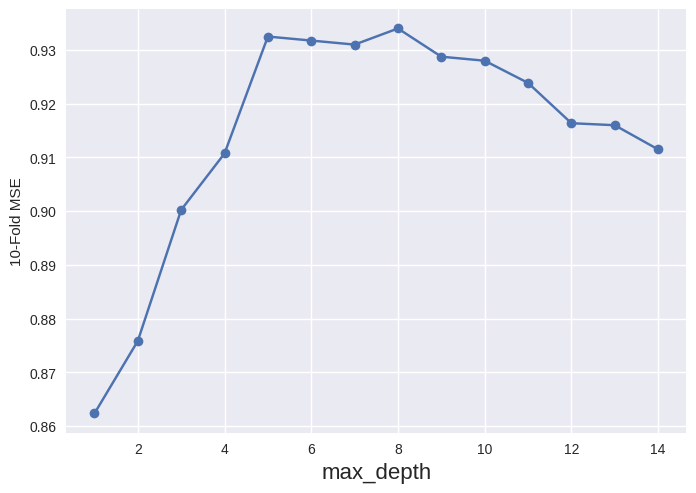

In [40]:
from sklearn.tree import DecisionTreeClassifier

maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }

# ... código aquí
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [41]:
maxDepthOptimo = grid.best_params_['max_depth']
# ... código aquí
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimo).fit(Xs_train,y_train)

print("Train: ",treeModel.score(Xs_train,y_train))
# fun fact: me equivoqué al copiar y dejé X_test. Haced la prueba, a ver qué pasa.
print("Test: ",treeModel.score(Xs_test,y_test)) 

y_pred = treeModel.predict(Xs_test)

Train:  0.9733683420855214
Test:  0.9550224887556222


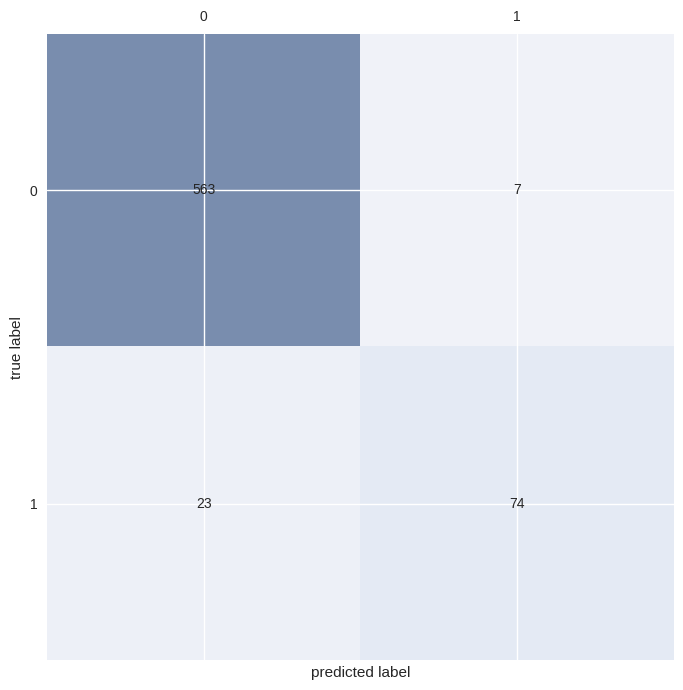

ACC:  0.9550224887556222
SEN:  0.7628865979381443
ESP:  0.987719298245614
PPV:  0.9135802469135802
FSC:  0.8314606741573032


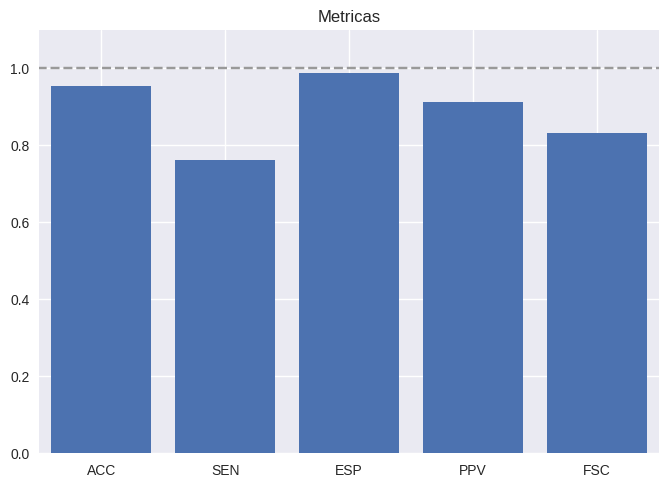

In [42]:
# ... código aquí
confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Como es un árbol individual, podemos representarlo:

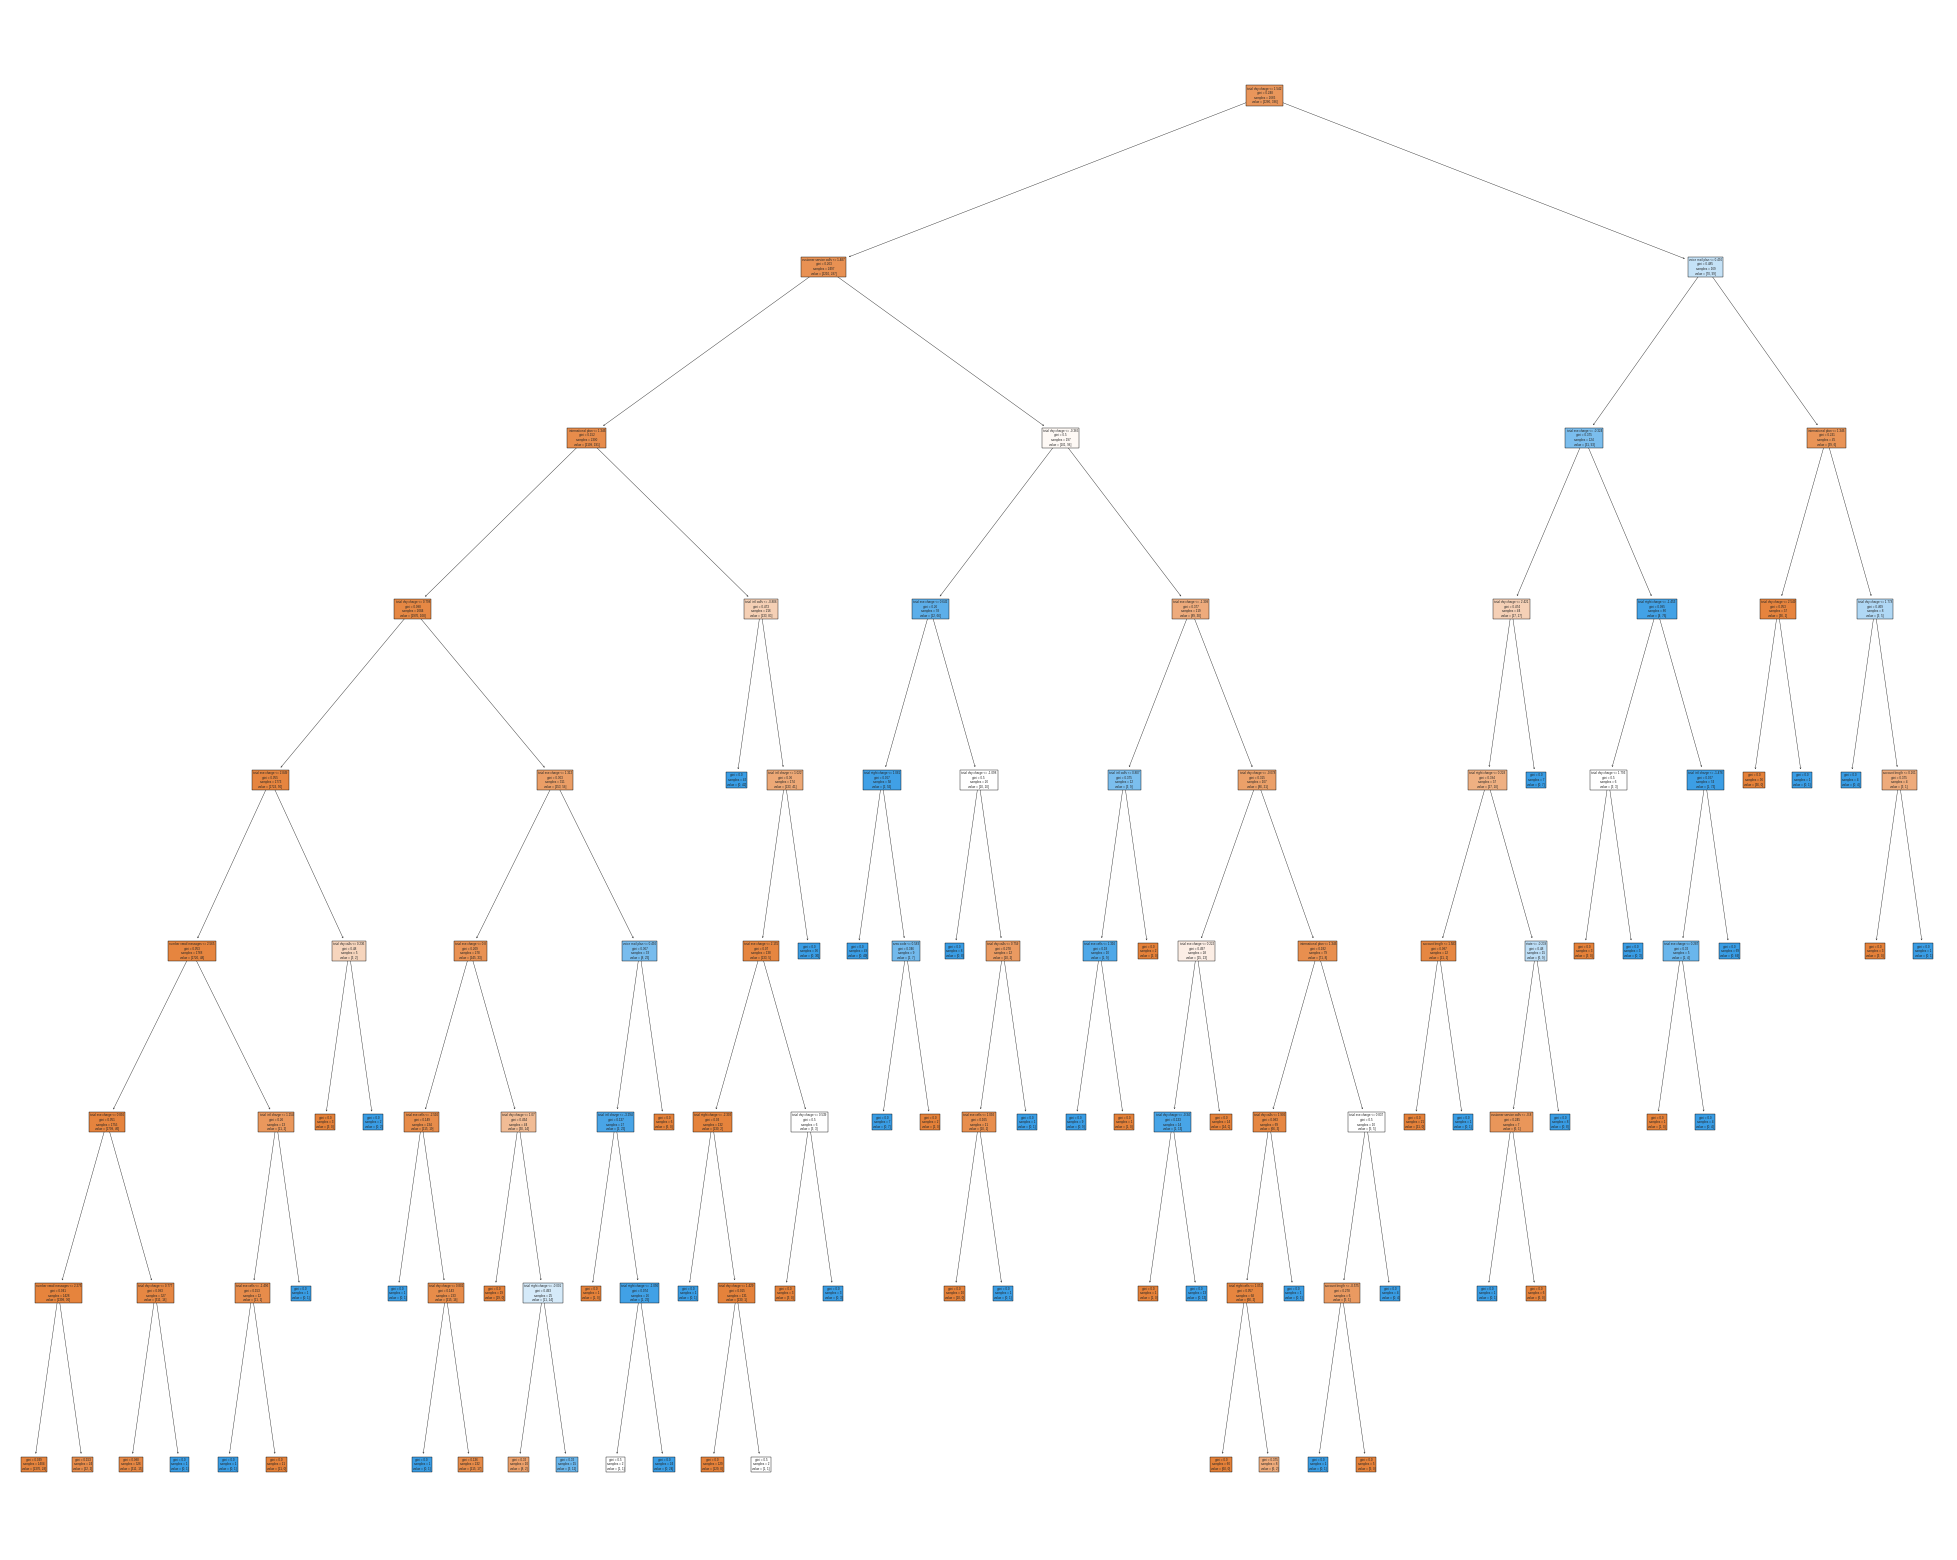

In [43]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(treeModel, feature_names=list(features), filled=True)

## 3.3 Random Forest

Comprobemos prestaciones para un algoritmo de Random Forest.

<div class = "alert alert-success">
EJERCICIO 8.10: Entrena un algoritmo de Random Forest y calcula las métricas obtenidas en el conjunto de test.
</div>

Fitting 10 folds for each of 14 candidates, totalling 140 fits
best mean cross-validation score: 0.938
best parameters: {'max_depth': 14}


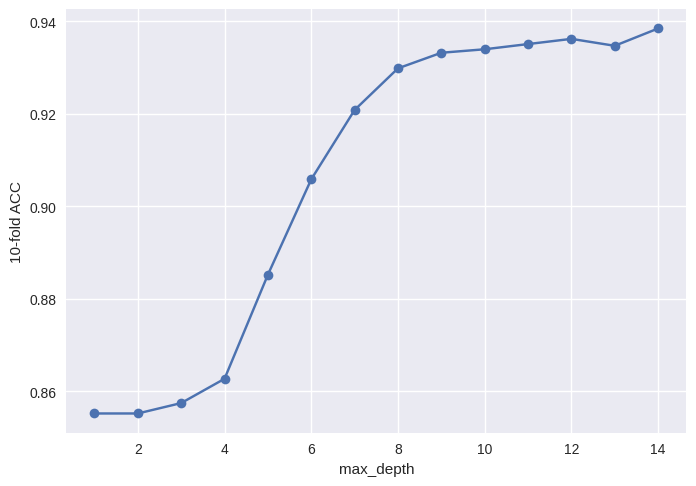

In [44]:
from sklearn.ensemble import RandomForestClassifier

# grid search
maxDepth   = range(1,15)
param_grid = {'max_depth': maxDepth}

# ... código aquí
grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200), param_grid=param_grid,cv=10, verbose=1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [51]:
maxDepthOptimo = grid.best_params_['max_depth']
# ... código aquí
rf = RandomForestClassifier(max_depth=9).fit(Xs_train,y_train)

print("Train: ",rf.score(Xs_train,y_train))
print("Test: ",rf.score(Xs_test,y_test)) 

y_pred = rf.predict(Xs_test)

Train:  0.9699924981245311
Test:  0.952023988005997


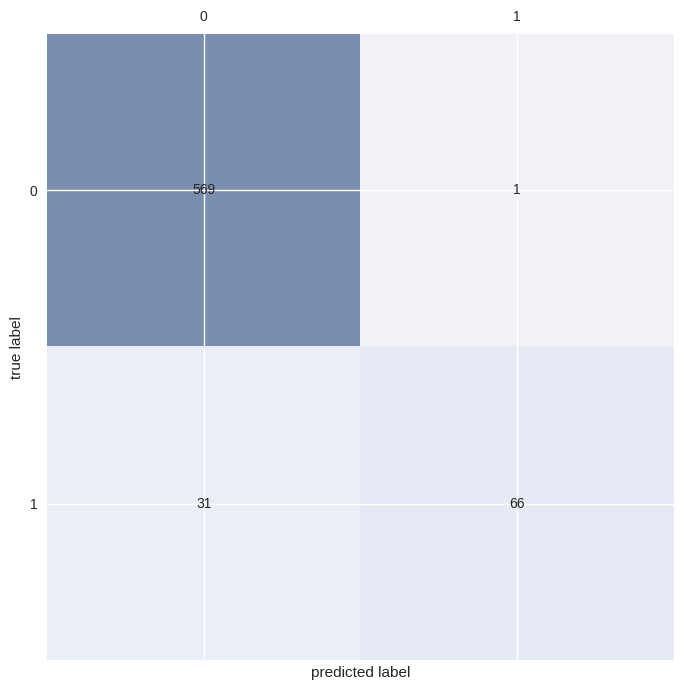

ACC:  0.952023988005997
SEN:  0.6804123711340206
ESP:  0.9982456140350877
PPV:  0.9850746268656716
FSC:  0.8048780487804879


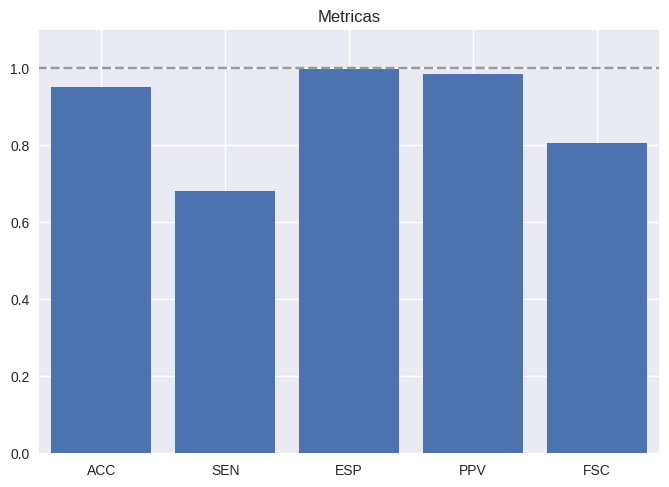

In [52]:
# ... código aquí
confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Con esto podríais evaluar cualquier algoritmo de sklearn, no sólo los que hemos visto en clase. Simplemente encontrad el (o los) parámetro que regula la complejidad, y ajustadlo con validación cruzada.